Gnomes are mining gold periodically reporting their bounty. On this mining operation there were two 
generation of tools being used, some gnomes were equipped with 1st generation tools, others with 2nd generation.
After the introduction of new generation tooling Gnome Inc CEO noticed that performance didn’t match his expectations. You as an analyst of Gnome Inc should confirm or reject CEO worries supporting your findings by cold hard data.



Формулировка основной и альтернативной гипотезы:

1)Нулевая гипотеза (H0) – это утверждение статус-кво, что никакой разницы между поколениями инструментов на самом деле нет.

2)Альтернативная гипотеза (H1) утверждает, что имеется некоторая разница между поколениями инструментов.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [3]:
data = pd.read_csv('gold_mining_data.csv')

In [4]:
data

,dwarf_id,hired_date,reported_date,gold_mined,hammer_date
0,1,2014-01-01,2014-01-31,656,2014-01-01
1,1,2014-01-01,2014-02-28,565,2014-01-01
2,1,2014-01-01,2014-03-31,516,2014-01-01
3,1,2014-01-01,2014-04-30,568,2014-01-01
4,1,2014-01-01,2014-05-31,556,2014-01-01
...,...,...,...,...,...
13488,2673,2015-08-01,2015-08-31,695,2015-01-01
13489,2674,2015-08-01,2015-08-31,573,2015-01-01
13490,2675,2015-08-01,2015-08-31,617,2015-01-01
13491,2676,2015-08-01,2015-08-31,609,2015-01-01


Немного изменим формат наших данных:
Превратим hammer_date в tool_generation, тип данных в столбцах reported_date и hired_date изменим на datetime и получим с их помощью новый столбец work_experience.

In [5]:
data['hammer_date'].replace(to_replace='2014-01-01', value=0, regex=True, inplace=True)
data['hammer_date'].replace(to_replace='2015-01-01', value=1, regex=True, inplace=True)
data['reported_date'] = pd.to_datetime(data['reported_date'], format="%Y-%m-%d")
data['hired_date'] = pd.to_datetime(data['hired_date'], format="%Y-%m-%d")
data['work_experience'] = (data['reported_date'] - data['hired_date']).dt.total_seconds()/(24*60*60)
new_columns = data.columns.values
new_columns[4] = 'tool_generation'
data.columns = new_columns

In [6]:
new_columns_list = list(new_columns)
new_columns_list.remove('hired_date')
old_data = data
data = data[new_columns_list]
data

,dwarf_id,reported_date,gold_mined,tool_generation,work_experience
0,1,2014-01-31,656,0,30.0
1,1,2014-02-28,565,0,58.0
2,1,2014-03-31,516,0,89.0
3,1,2014-04-30,568,0,119.0
4,1,2014-05-31,556,0,150.0
...,...,...,...,...,...
13488,2673,2015-08-31,695,1,30.0
13489,2674,2015-08-31,573,1,30.0
13490,2675,2015-08-31,617,1,30.0
13491,2676,2015-08-31,609,1,30.0


Визуально оценим тип распределения данных:

<AxesSubplot:>

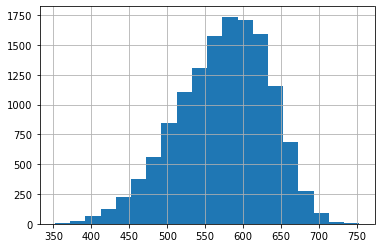

In [7]:
data['gold_mined'].hist(bins = 20)

<AxesSubplot:>

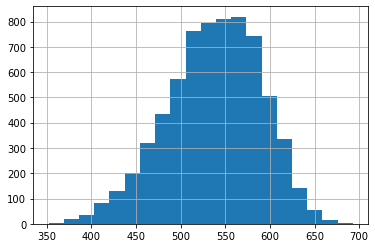

In [8]:
data[data['tool_generation'] == 0]['gold_mined'].hist(bins = 20)

<AxesSubplot:>

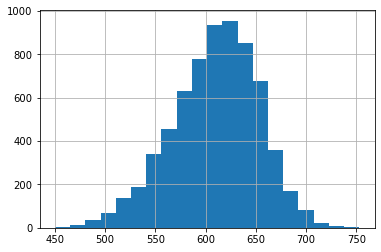

In [9]:
data[data['tool_generation'] == 1]['gold_mined'].hist(bins = 20)

Распределение похоже на нормальное.

Более детально рассмотрим параметры распределения для каждого из поколений инструмента.

In [10]:
stats = data.groupby(['tool_generation'])['gold_mined'].agg(['mean', 'count', 'std'])
ci95_hi = []
ci95_lo = []
gold_mined_p_std = []
gold_mined_m_std = []
for i in stats.index:
    m, c, s = stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))
    gold_mined_p_std.append(m + s)
    gold_mined_m_std.append(m - s)
    
stats['ci95_hi'] = ci95_hi
stats['ci95_lo'] = ci95_lo
stats['gold_mined_p_std'] = gold_mined_p_std
stats['gold_mined_m_std'] = gold_mined_m_std
stats

,mean,count,std,ci95_hi,ci95_lo,gold_mined_p_std,gold_mined_m_std
tool_generation,,,,,,,
0,537.112292,6777,52.587743,538.364342,535.860241,589.700035,484.524549
1,609.660810,6716,42.881518,610.686393,608.635227,652.542328,566.779292


Посмотрим на зависимость среднего кол-ва добытого золота от даты добычи:

<AxesSubplot:xlabel='reported_date'>

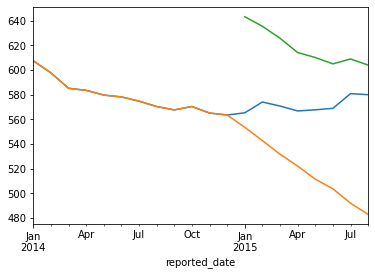

In [11]:
data.groupby(['reported_date'])['gold_mined'].mean().plot()
data[data['tool_generation'] == 0].groupby(['reported_date'])['gold_mined'].mean().plot()
data[data['tool_generation'] == 1].groupby(['reported_date'])['gold_mined'].mean().plot()

Похоже что со временем запасы в шахте истощаются и добывать золото становиться труднее.
Добавим счетчик который будет считать какой идет день работы шахты.

In [12]:
data['days_count'] = (data['reported_date'] - pd.to_datetime('2014-01-01', format="%Y-%m-%d")).dt.total_seconds()/(24*60*60)
data

,dwarf_id,reported_date,gold_mined,tool_generation,work_experience,days_count
0,1,2014-01-31,656,0,30.0,30.0
1,1,2014-02-28,565,0,58.0,58.0
2,1,2014-03-31,516,0,89.0,89.0
3,1,2014-04-30,568,0,119.0,119.0
4,1,2014-05-31,556,0,150.0,150.0
...,...,...,...,...,...,...
13488,2673,2015-08-31,695,1,30.0,607.0
13489,2674,2015-08-31,573,1,30.0,607.0
13490,2675,2015-08-31,617,1,30.0,607.0
13491,2676,2015-08-31,609,1,30.0,607.0


Посмотрим как коррелируют между собой переменные:

<AxesSubplot:>

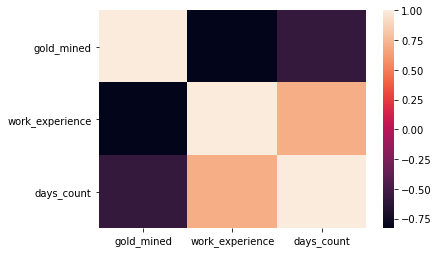

In [13]:
sns.heatmap(data[data['tool_generation'] == 0][['gold_mined', 'work_experience', 'days_count']].corr())

<AxesSubplot:>

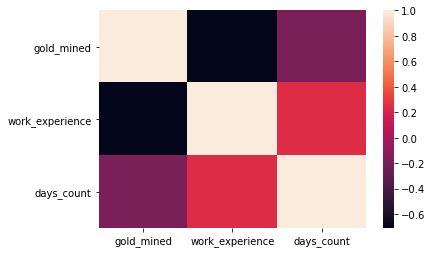

In [80]:
sns.heatmap(data[data['tool_generation'] == 1][['gold_mined', 'work_experience', 'days_count']].corr())

Можно отметить только странную, достаточно сильную обратную корреляцию между опытом работы и добытым золотом.

Возможно количество добываемого золота может зависить от времени года, извлечем из reported_date номер месяца в формате который будет удобно использовать для обучения модели линейной регрессии:

In [14]:
for i in range(1, 13):
    data[f'{i}'] = (data['reported_date'].apply(lambda x: x.month) == i).astype(int)
    
data

,dwarf_id,reported_date,gold_mined,tool_generation,work_experience,days_count,1,2,3,4,5,6,7,8,9,10,11,12
0,1,2014-01-31,656,0,30.0,30.0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,2014-02-28,565,0,58.0,58.0,0,1,0,0,0,0,0,0,0,0,0,0
2,1,2014-03-31,516,0,89.0,89.0,0,0,1,0,0,0,0,0,0,0,0,0
3,1,2014-04-30,568,0,119.0,119.0,0,0,0,1,0,0,0,0,0,0,0,0
4,1,2014-05-31,556,0,150.0,150.0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13488,2673,2015-08-31,695,1,30.0,607.0,0,0,0,0,0,0,0,1,0,0,0,0
13489,2674,2015-08-31,573,1,30.0,607.0,0,0,0,0,0,0,0,1,0,0,0,0
13490,2675,2015-08-31,617,1,30.0,607.0,0,0,0,0,0,0,0,1,0,0,0,0
13491,2676,2015-08-31,609,1,30.0,607.0,0,0,0,0,0,0,0,1,0,0,0,0


Обучим модель линейной регресии и посмотрим насколько хорошо она предсказывает наши данные.

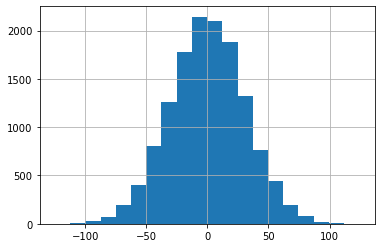

In [112]:
x = data.iloc[:, -15:]
x_test = data.iloc[:, -15:-12]
y = data['gold_mined']
y_pred = LinearRegression().fit(x, y).predict(x)
(y_pred - y).hist(bins = 20)
y_pred_test = LinearRegression().fit(x_test, y).predict(x_test)


<AxesSubplot:>

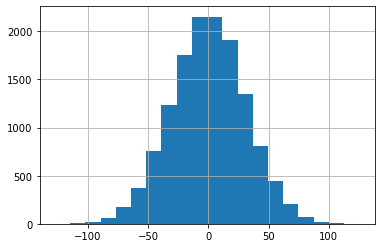

In [113]:
(y_pred_test - y).hist(bins = 20)

In [114]:
LinearRegression().fit(x, y).coef_

array([16.67684157, -0.38061678,  0.03433962,  2.49556245,  3.05278519,
        2.32044987,  0.39403978, -0.41599477, -1.34302294, -1.9901485 ,
       -2.69132318,  1.15531963,  0.03860055, -2.21907528, -0.79719282])

In [115]:
LinearRegression().fit(x_test, y).coef_

array([16.68492156, -0.3796218 ,  0.02715216])

In [116]:
r2_score(y, y_pred)

0.7371413761592986

In [117]:
r2_score(y, y_pred_test)

0.7363917292937313

In [118]:
x = sm.add_constant(x)

model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             gold_mined   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     2700.
Date:                Sat, 30 Oct 2021   Prob (F-statistic):               0.00
Time:                        19:15:26   Log-Likelihood:                -65413.
No. Observations:               13493   AIC:                         1.309e+05
Df Residuals:                   13478   BIC:                         1.310e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             560.0921      1.224    4

In [119]:
x_test = sm.add_constant(x_test)

model = sm.OLS(y, x_test)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             gold_mined   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                 1.256e+04
Date:                Sat, 30 Oct 2021   Prob (F-statistic):               0.00
Time:                        19:15:28   Log-Likelihood:                -65432.
No. Observations:               13493   AIC:                         1.309e+05
Df Residuals:                   13489   BIC:                         1.309e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             609.3711      1.164    5

Вывод: Вес предиктора tool_generation имеет доверительный интервал с уровнем доверия, 95 % = [14.722, 18.648], что является подтверждением H1 о том, что присутствует разница между поколениями инструмента, причем новое поколение показывает себя лучше.
Замечания: Мы использовали один набор данных для обучения и проверки модели, это не очень хорошо, но для линейной регрессии это допустимо. Коэффициент R-squared = 0.74 на мой взгляд говорит о том, что линейная регрессия вполне подходит для наших данных, но далеко не идеально может их предсказывать.

Ниже идут графики которые не попали в финальный отчет, но помогли мне лучше понять данные.
Я оставлю к ним комментарии тоже.

Гистограмы показывающие какое количество записей (ось y) было внесенно с конкретным опытом работы в днях (ось x) для разного поколения инструмента.

<AxesSubplot:>

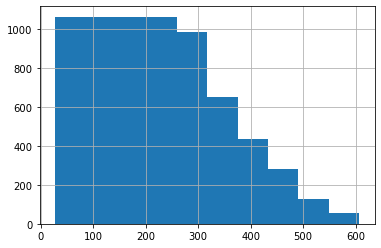

In [120]:
data[data['tool_generation'] == 0]['work_experience'].hist()

<AxesSubplot:>

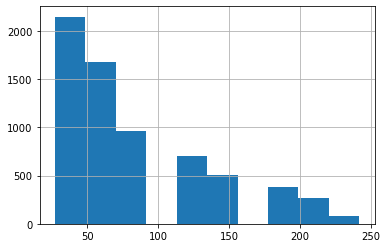

In [121]:
data[data['tool_generation'] == 1]['work_experience'].hist()

График показывающий в какие месяцы работали гномы с разным поколением инструмента.

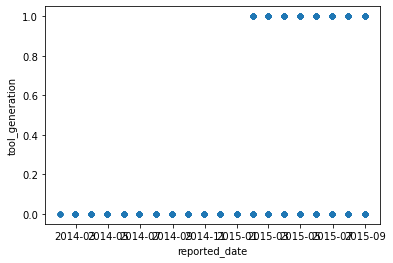

In [122]:
data.plot(x="reported_date", y="tool_generation", kind="scatter")
plt.show()

Странные графики которые показывают то, что с увеличением опыта работа уменьшается количество добытого золота, логично предположить, что связь косвенная. Однако можно так же предположить, что гномы со временем начинают халтурить.

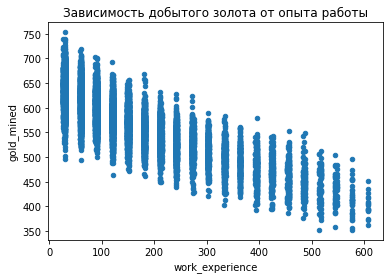

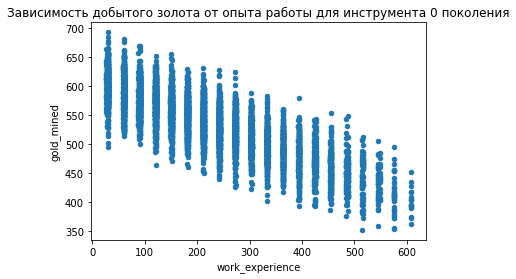

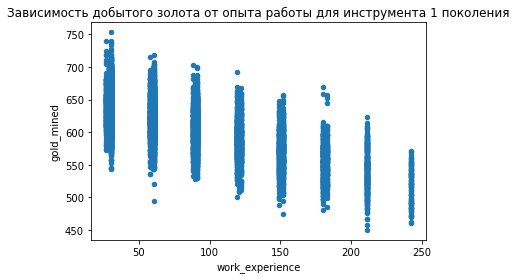

In [124]:
data.plot(x="work_experience", y="gold_mined", kind="scatter", title = 'Зависимость добытого золота от опыта работы')
plt.show()
data[data['tool_generation'] == 0].plot(x="work_experience", y="gold_mined", kind="scatter", title = 'Зависимость добытого золота от опыта работы для инструмента 0 поколения')
plt.show()
data[data['tool_generation'] == 1].plot(x="work_experience", y="gold_mined", kind="scatter", title = 'Зависимость добытого золота от опыта работы для инструмента 1 поколения')
plt.show()

Странные графики которые показывают то, что с течением времени немного уменьшается среднее количество добытого золота и достаточно сильно растет размах. Небольшой рост в центре связан как раз с внедрением инструментов нового поколения. Возможно это можно включить в основную часть отчета.

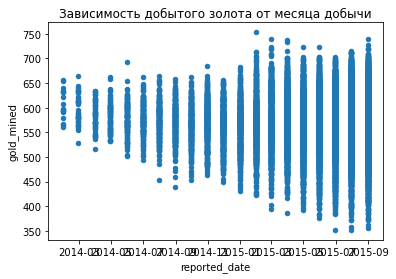

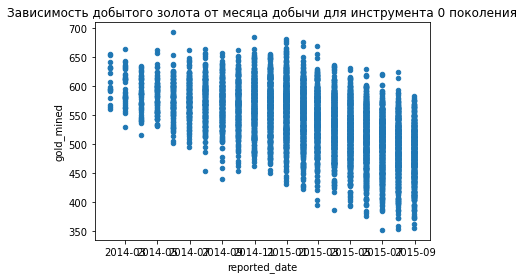

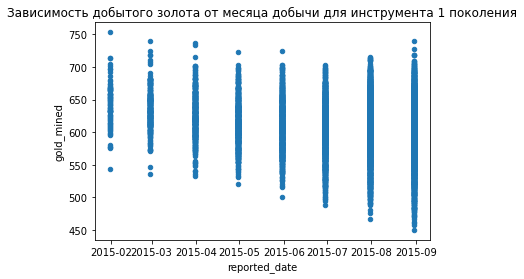

In [125]:
data.plot(x="reported_date", y="gold_mined", kind="scatter", title = 'Зависимость добытого золота от месяца добычи')
plt.show()
data[data['tool_generation'] == 0].plot(x="reported_date", y="gold_mined", kind="scatter", title = 'Зависимость добытого золота от месяца добычи для инструмента 0 поколения')
plt.show()
data[data['tool_generation'] == 1].plot(x="reported_date", y="gold_mined", kind="scatter", title = 'Зависимость добытого золота от месяца добычи для инструмента 1 поколения')
plt.show()

Не смог найти применение этим бокс плотам.

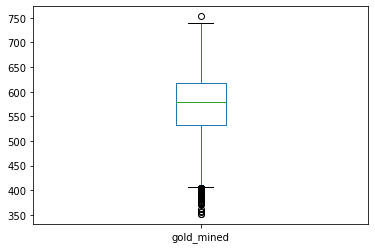

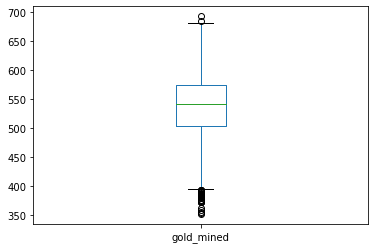

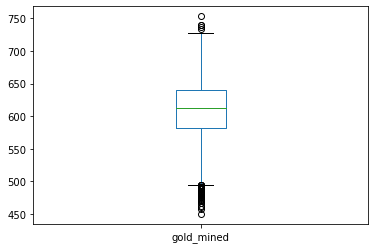

In [89]:
data.plot(y="gold_mined", kind="box")
plt.show()
data[data['tool_generation'] == 0].plot(y="gold_mined", kind="box")
plt.show()
data[data['tool_generation'] == 1].plot(y="gold_mined", kind="box")
plt.show()

Похоже гномов не увольняют с работы.

In [90]:
data.groupby(['dwarf_id'])['work_experience'].max()

dwarf_id
1       607.0
2       607.0
3       607.0
4       607.0
5       607.0
        ...  
2673     30.0
2674     30.0
2675     30.0
2676     30.0
2677     30.0
Name: work_experience, Length: 2677, dtype: float64

<AxesSubplot:xlabel='dwarf_id'>

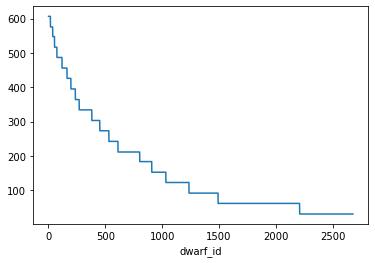

In [91]:
data.groupby(['dwarf_id'])['work_experience'].max().plot()

Штат сильно растет последние 3 месяца, поэтому значительная часть гномов имеет опыт работы меньше 100 дней.

<AxesSubplot:>

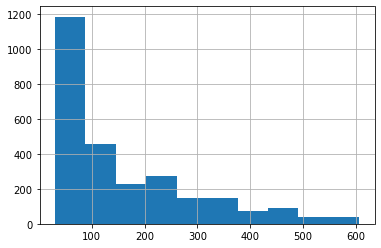

In [92]:
data.groupby(['dwarf_id'])['work_experience'].max().hist()

Проверка на то, что гном не менял инструмент и всю карьеру работает одним и тем же.

In [93]:
data.groupby(['dwarf_id'])['tool_generation'].nunique().mean()

1.0

Гномов работающих новым инструментом на момент конца исследования в 4 раза больше, чем гномов работающих старым.

In [94]:
data.groupby(['tool_generation'])['dwarf_id'].nunique()

tool_generation
0     531
1    2146
Name: dwarf_id, dtype: int64

В среднем гном работающий с инструментом старого поколения успел отработать почти 14 месяцев, а гном работающий с инструментом нового поколения всего 3.

In [95]:
data.groupby(['tool_generation', 'dwarf_id']).count().groupby(['tool_generation']).mean()

,reported_date,gold_mined,work_experience,days_count,1,2,3,4,5,6,7,8,9,10,11,12
tool_generation,,,,,,,,,,,,,,,,
0,12.762712,12.762712,12.762712,12.762712,12.762712,12.762712,12.762712,12.762712,12.762712,12.762712,12.762712,12.762712,12.762712,12.762712,12.762712,12.762712
1,3.129543,3.129543,3.129543,3.129543,3.129543,3.129543,3.129543,3.129543,3.129543,3.129543,3.129543,3.129543,3.129543,3.129543,3.129543,3.129543


In [96]:
data.groupby(['tool_generation', 'dwarf_id'])['gold_mined'].mean()

tool_generation  dwarf_id
0                1           503.60
                 2           503.25
                 3           494.90
                 4           502.50
                 5           506.80
                              ...  
1                2673        695.00
                 2674        573.00
                 2675        617.00
                 2676        609.00
                 2677        622.00
Name: gold_mined, Length: 2677, dtype: float64

Наглядное сравнение гистограм.

tool_generation
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: gold_mined, dtype: object

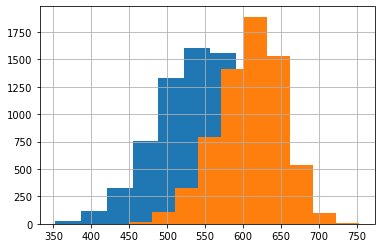

In [127]:
data.groupby(['tool_generation'])['gold_mined'].hist()

In [128]:
data1 = data.groupby(['tool_generation', 'dwarf_id']).mean()

In [129]:
mask1 = []
for i in data1.index: 
    mask1.append(0 in i)
    
mask2 = [] 
for i in data1.index: 
    mask2.append(0 not in i)
    
new_index = []
for i in data1.index:
    new_index.append(i[1])
    
data1.index = new_index

Тут тоже можно увидеть импакт внедрения инструментов второго поколения на стыке синего и оранжевого графиков.

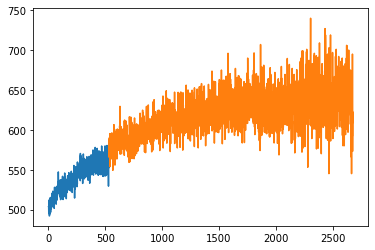

In [130]:
data1[mask1]['gold_mined'].plot()
data1[mask2]['gold_mined'].plot()
plt.show()

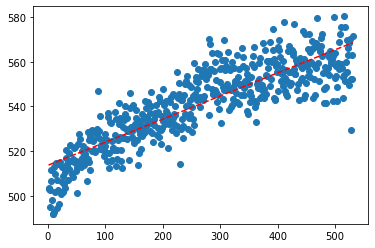

In [131]:
data3 = data1[mask1]
x = data3.index
y = data3['gold_mined']
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

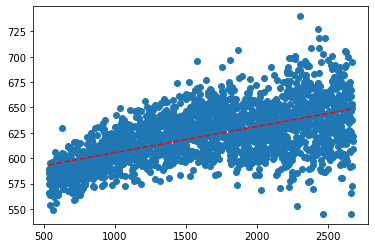

In [132]:
data3 = data1[mask2]
x = data3.index
y = data3['gold_mined']
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()